# Delayed Self-Heterodyne Phase Noise Measurements With Coherent Phase Modulation Detection

This notebook focuses on metodologies presented in the work: 

[Delayed Self-Heterodyne Phase Noise Measurements With Coherent Phase Modulation Detection (2012)](https://ieeexplore.ieee.org/document/6064871)


I am starting with this work, because it study a system with only one laser

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
from optic.models.devices import photodiode, basicLaserModel
from optic.models.channels import linearFiberChannel
from optic.dsp.core import phaseNoise, firFilter, pulseShape, signal_power ,delaySignal
from optic.models.amplification import OSA, get_spectrum
from optic.utils import parameters
from optic.plot import plotPSD
from scipy.constants import h, c
from scipy.signal import hilbert
from scipy.signal.windows import hamming
from scipy.ndimage import shift
from IPython.display import display, Math
from commpy.utilities import upsample

sys.path.append('..\..\Functions')

from laser_dfb import *
from laser_cw import *
from AuxiliaryFunctions import *

fontSmall = {'family':'serif', 'weight':'normal', 'size':12}
font = {'family':'serif', 'weight':'normal', 'size':16}
fontTitle = {'family':'serif', 'weight':'normal', 'size':20}

# Optical domain demonstration: 50:50 Coupling, SMF, and PM modulation

## Laser generation

In [7]:
laser_dfb_parameters = parameters()
laser_dfb_parameters.noise_terms = True
laser_dfb_parameters.v       = 1.0       # [cm3]  active layer volume
laser_dfb_parameters.tau_n   = 0.33e-9   # [s]    electron lifetime
laser_dfb_parameters.a0      = 2.50e-6   # [cm2]  active layer gain coefficient
laser_dfb_parameters.vg      = 4.52e+9   # [cm/s] group velocity
laser_dfb_parameters.n_t     = 8.2e6     # [cm-1] carrier density at transparency
laser_dfb_parameters.epsilon = 4.58e-8   # [cm3] gain compression factor
laser_dfb_parameters.tau_p   = 7.15e-12  # [s] photon lifetime
laser_dfb_parameters.gamma   = 1.0       # mode confinement factor
laser_dfb_parameters.beta    = 3.54e-5   # fraction of spontaneous emission coupling
laser_dfb_parameters.alpha   = 1.55      # linewidth enchancement factor
laser_dfb_parameters.sigma   = 2e-20     # gain cross section
laser_dfb_parameters.i_bias  = 0.0129    # [A] i_bias
laser_dfb_parameters.i_max   = 0.0300    # [A] i_max
laser_dfb_parameters.eta_0   = 0.21      # total differential quantum efficiency
laser_dfb_parameters.lmbd    = 1540e-9   # [m] wavelength

In [9]:
# simulation parameters
SpS = 256    # Samples per Symbol
Rs = 2.5e9   # Symbol rate (for OOK case Rs = Rb)

Tsymb = 1/Rs       # Symbol period in seconds
Fs = 1/(Tsymb/SpS) # Signal sampling frequency (samples/second)
Ts = 1/Fs          # Sampling period

# generate pseudo-random bit sequence
bitsTx = np.ones(2**9)
n = np.arange(0, bitsTx.size)

# upsampling
symbolsUp = upsample(bitsTx, SpS)

# typical NRZ pulse
pulse = pulseShape('rect', SpS)
pulse = pulse/max(abs(pulse))

# pulse formatting (not necessary for CW operation)
sigTx = firFilter(pulse, symbolsUp)

sigTx = shift(sigTx, int(SpS/2), cval=sigTx[0])  # Shifts the signal to the right and fill the new created empty values with a constant = cval 
t = np.arange(0,SpS*len(bitsTx))*Ts

print(f'Samples: {SpS*len(bitsTx)}')

Samples: 131072


d:\GitHub Repositories\Laser-Study\Projects\Delayed_Self_Heterodyne\..\..\Functions\laser_dfb.py:119: RuntimeWarning: invalid value encountered in sqrt
  fs = np.random.randn()*np.sqrt(2*dss/self.t_step)
d:\GitHub Repositories\Laser-Study\Projects\Delayed_Self_Heterodyne\..\..\Functions\laser_dfb.py:121: RuntimeWarning: invalid value encountered in sqrt
  fp = np.random.randn()*np.sqrt(2*dpp/self.t_step)


I_threshold: 9.990 mA
I_on: 42.900 mA
I_off: 42.900 mA
Power (mW): 2.7487030935778862


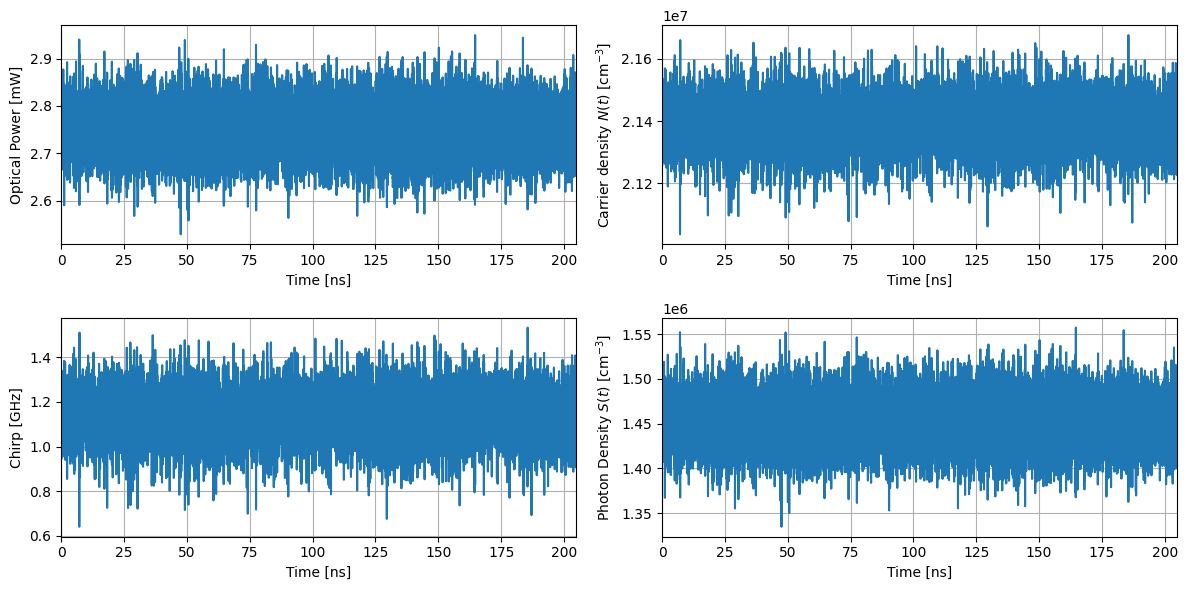

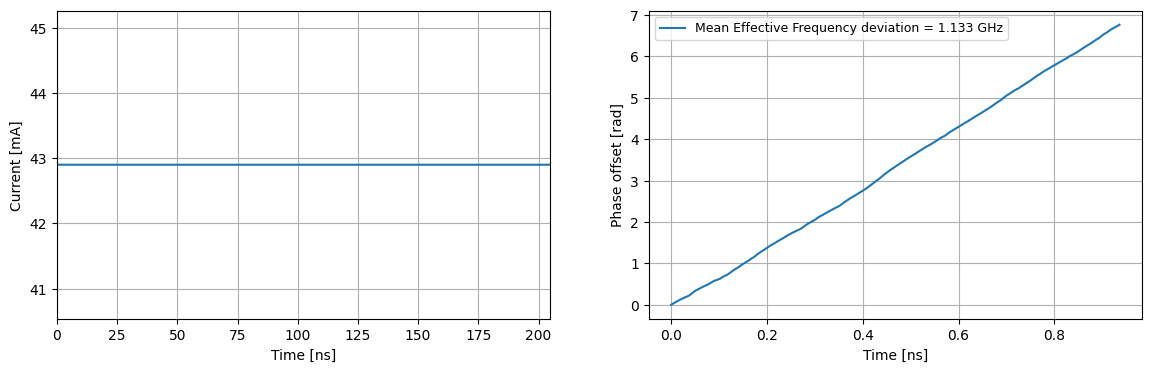

In [65]:
laser_dfb_parameters.noise_terms = True
laser1 = laser_dfb(laser_dfb_parameters)
sol = laser1.solve(t, sigTx)

laser1.plot()
print('I_threshold: %.3f mA'%(1e3*laser1.ith))
print('I_on: %.3f mA'%(1e3*np.real(laser1.current.max())))
print('I_off: %.3f mA'%(1e3*np.real(laser1.current.min())))
print(f'Power (mW): {np.mean(laser1.power)*1e3}')

fig, ax = plt.subplots(1,2)
fig.set_figheight(4)
fig.set_figwidth(14)

ax[0].plot(1e9*laser1.t, 1e3*laser1.current)
ax[0].set_xlabel('Time [ns]')
ax[0].set_ylabel('Current [mA]')
ax[0].set_xlim([1e9*t.min(), 1e9*t.max()])
ax[0].grid(True)

EffFreqDeviation = np.round(1e-9*(laser1.phase[-1]-laser1.phase[0])/(2*np.pi*laser1.t[-1]),3)
ax[1].plot(1e9*laser1.t[:600], laser1.phase[:600]-laser1.phase[0], label=f'Mean Effective Frequency deviation = {EffFreqDeviation} GHz')
ax[1].set_xlabel('Time [ns]')
ax[1].set_ylabel('Phase offset [rad]')
# ax[1].set_xlim([0,1])
# ax[1].set_ylim([0,7])
ax[1].legend(fontsize=9)
ax[1].grid(True)

Text(0.5, 1.0, 'DFB laser spectrum')

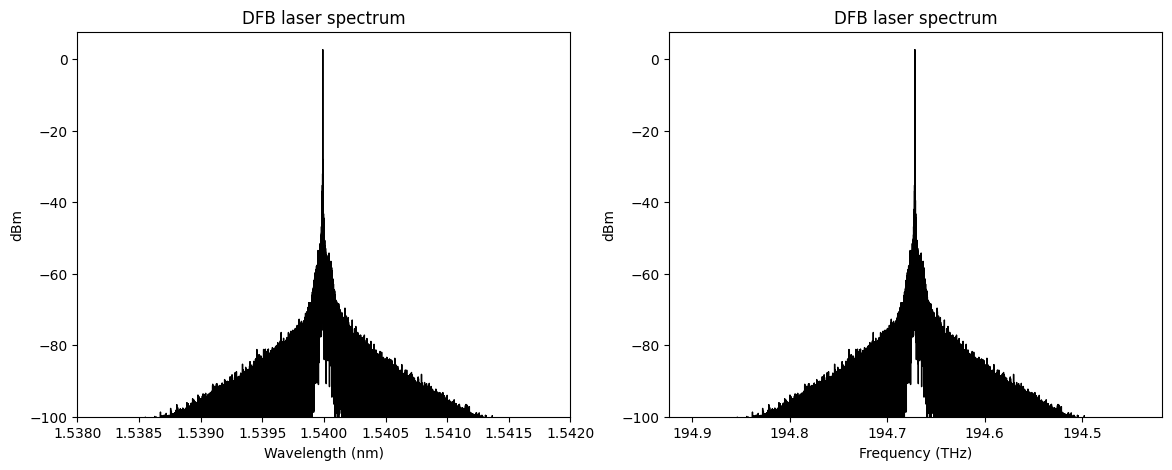

In [67]:
fig, ax = plt.subplots(1,2)
fig.set_figheight(5)
fig.set_figwidth(14)

freq, spectrum = get_spectrum(laser1.e_out, Fs=Fs, Fc=c/laser1.lmbd)
ax[0].plot(freq*1e6, spectrum, color='black',linewidth = 1)
ax[0].set_xlim(1.538,1.542)
ax[0].set_ylim(-100,np.max(spectrum)+5)
ax[0].set_ylabel('dBm')
ax[0].set_xlabel('Wavelength (nm)')
ax[0].set_title('DFB laser spectrum')

freq, spectrum = get_spectrum(laser1.e_out, Fs=Fs, Fc=c/laser1.lmbd, xunits='hz')
ax[1].plot(freq*1e-12, spectrum, color='black',linewidth = 1)
ax[1].set_xlim(c/1.538*1e-6,c/1.542*1e-6)
ax[1].set_ylim(-100,np.max(spectrum)+5)
ax[1].set_ylabel('dBm')
ax[1].set_xlabel('Frequency (THz)')
ax[1].set_title('DFB laser spectrum')

## 50:50 Coupling and SMF 12km

The SMF parameters were gathered in the following references:
- [Corning-SMF-28E-Single-Mode-Bare-Fiber-Fiber-Optic-Center](https://focenter.com/media/wysiwyg/docs/Corning-Corning-SMF-28E-Single-Mode-Bare-Fiber-Fiber-Optic-Center.pdf) 
- [Nonlinear Fiber Optics - Govind P. Agrawal](https://www.sciencedirect.com/book/9780120451401/nonlinear-fiber-optics#:~:text=This%20book%20consists%20of%2010%20chapters%20and%20begins,in%20the%20field%20of%20fiber%20optics%20is%20provided.)

From the chapter 2 of "*Nonlinear Fiber Optics - Govind P. Agrawal*", the Fiber Nonlinear parameter ($\gamma$) can be calculated as: $$\gamma = \frac{n_2 \cdot \omega_0}{c \cdot A_{eff}}$$
and will result in $\approx 1.2~W^{-1}\cdot km^{-1}$ for 1540nm. Considering $n_2 \approx 2.36 \cdot 10^{-20}~m^2/W$ and $A_{eff} \approx 80 \cdot 10^{-12}~m^2$.

In [69]:
KConst = 0.5         # Coupling Constant (0 to 1)
KPhase = (1/2)*np.pi   # Coupling Phase Delay between arms (rad)

SMFLen = 12          # Single Mode Fiber Length (km)
SMFAtt = 0.22        # Single Mode Fiber Attenuation (dB/km)
SMFGamma = 1.2       # Single Mode Fiber Nonlinear parameter (1/(W*km))
SMFDisp = 16         # Single Mode Fiber Chromatic Dispersion parameter (ps/nm/km)

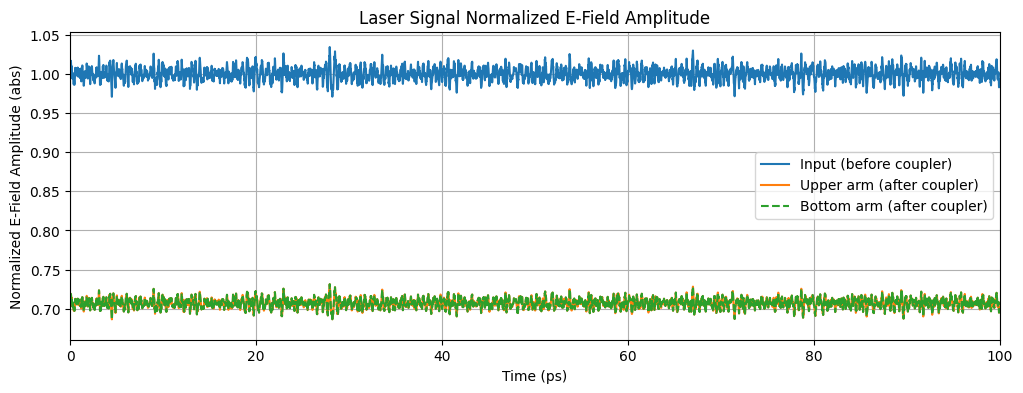

In [100]:
timeArray = np.linspace(0,Ts*bitsTx.size,SpS*bitsTx.size)

plt.figure(figsize=(12,4))

plt.plot(timeArray*1e12,np.abs(laser1.e_out)/np.mean(np.abs(laser1.e_out)), label='Input (before coupler)')
plt.plot(timeArray*1e12,np.abs(laser1.e_out*np.sqrt(KConst))/np.mean(np.abs(laser1.e_out)), label='Upper arm (after coupler)')
plt.plot(timeArray*1e12,np.abs(laser1.e_out*np.sqrt(1-KConst))/np.mean(np.abs(laser1.e_out)), label='Bottom arm (after coupler)', linestyle='--')
plt.xlim(0,100)
plt.xlabel('Time (ps)')
plt.ylabel('Normalized E-Field Amplitude (abs)')
plt.title('Laser Signal Normalized E-Field Amplitude')
plt.legend()
plt.grid()

Using the Split-Step Fourier Method (SSFM) for non-linear fibers (The Manakov model, considering that the PMD effects is much lower than the nonlinear effects), the nonlinear phase rotation step is given:
$$ E_x(z,t) \leftarrow \left[E_x(z,t) \exp \left[ -j8\gamma/9 \left( |E_x(z,t)|^2 + |E_y(z,t)|^2 \right) h_z \right]\right] $$
$$ E_y(z,t) \leftarrow \left[E_y(z,t) \exp \left[ -j8\gamma/9 \left( |E_x(z,t)|^2 + |E_y(z,t)|^2 \right) h_z \right]\right] $$

If we measure term $ \exp \left[ -j8\gamma/9 \left( |E_x(z,t)|^2 + |E_y(z,t)|^2 \right) h_z \right] $ using the obtained parameters of the E-Field (max value), SMF length and the Fiber Nonlinear parameter ($\gamma$), we get:


In [101]:
hz = 0.1  # Horizontal step in km
PhaseRotation = (np.max(np.abs(np.real(laser1.e_out)))*np.sqrt(KConst))**2 * SMFGamma * (8/9) * hz
display(Math('Phase~Rotation:~~~~~~From~one~step = %5.6f ~rad ~~~|~~~ From~all~steps~summed = %5.6f ~rad' %(PhaseRotation,PhaseRotation*SMFLen/hz)))

<IPython.core.display.Math object>

This value is considerable low, so it is justified the use of a *Linear Fiber Model*. No Y polarization was considered in this case.

In [108]:
LinearFiber_parameters = parameters()
LinearFiber_parameters.L = SMFLen           # [km] total fiber length
LinearFiber_parameters.alpha = SMFAtt       # [dB/km] fiber attenuation parameter 
LinearFiber_parameters.D = SMFDisp          # [ps/nm/km] chromatic dispersion parameter
LinearFiber_parameters.Fc = c/laser1.lmbd   # [Hz] carrier frequency
LinearFiber_parameters.Fs = Fs              # [Hz] sampling frequency 

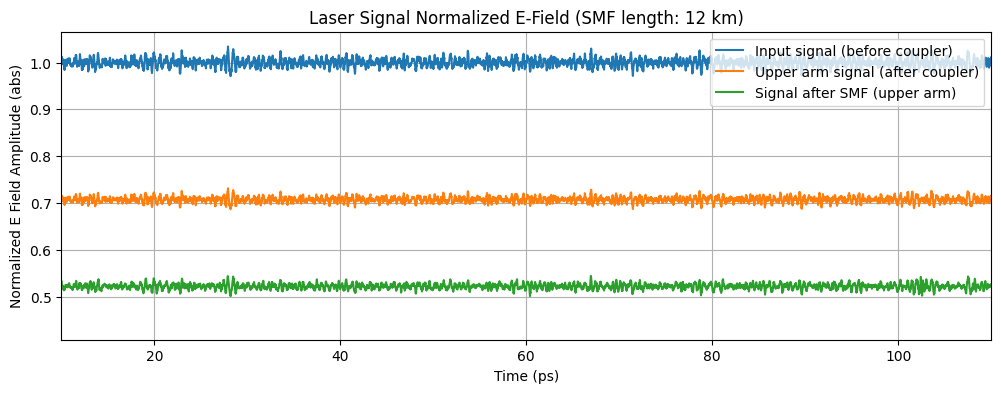

In [116]:
EUpper = linearFiberChannel(laser1.e_out*np.sqrt(KConst),LinearFiber_parameters)  

timeArray = np.linspace(0,Ts*bitsTx.size,SpS*bitsTx.size)

plt.figure(figsize=(12,4))

plt.plot(timeArray*1e12,np.abs(laser1.e_out)/np.mean(np.abs(laser1.e_out)),label='Input signal (before coupler)')
plt.plot(timeArray*1e12,np.abs(laser1.e_out*np.sqrt(KConst))/np.mean(np.abs(laser1.e_out)),label='Upper arm signal (after coupler)')
plt.plot(timeArray*1e12,np.abs(EUpper)/np.mean(np.abs(laser1.e_out)), label='Signal after SMF (upper arm)')
plt.xlim(10,110)
# plt.ylim(np.min(np.real(laser1.e_out)),np.max(np.real(laser1.e_out)))
plt.xlabel('Time (ps)')
plt.ylabel('Normalized E Field Amplitude (abs)')
plt.title(f'Laser Signal Normalized E-Field (SMF length: {SMFLen} km)')
plt.legend()
plt.grid()

The graph above don't consider the group delay $\tau$ caused by the fiber

In [117]:
tau = SMFLen/(c*1e-3)    # Fiber Delay

## Phase Modulation (bottom arm) and Photodiode detection

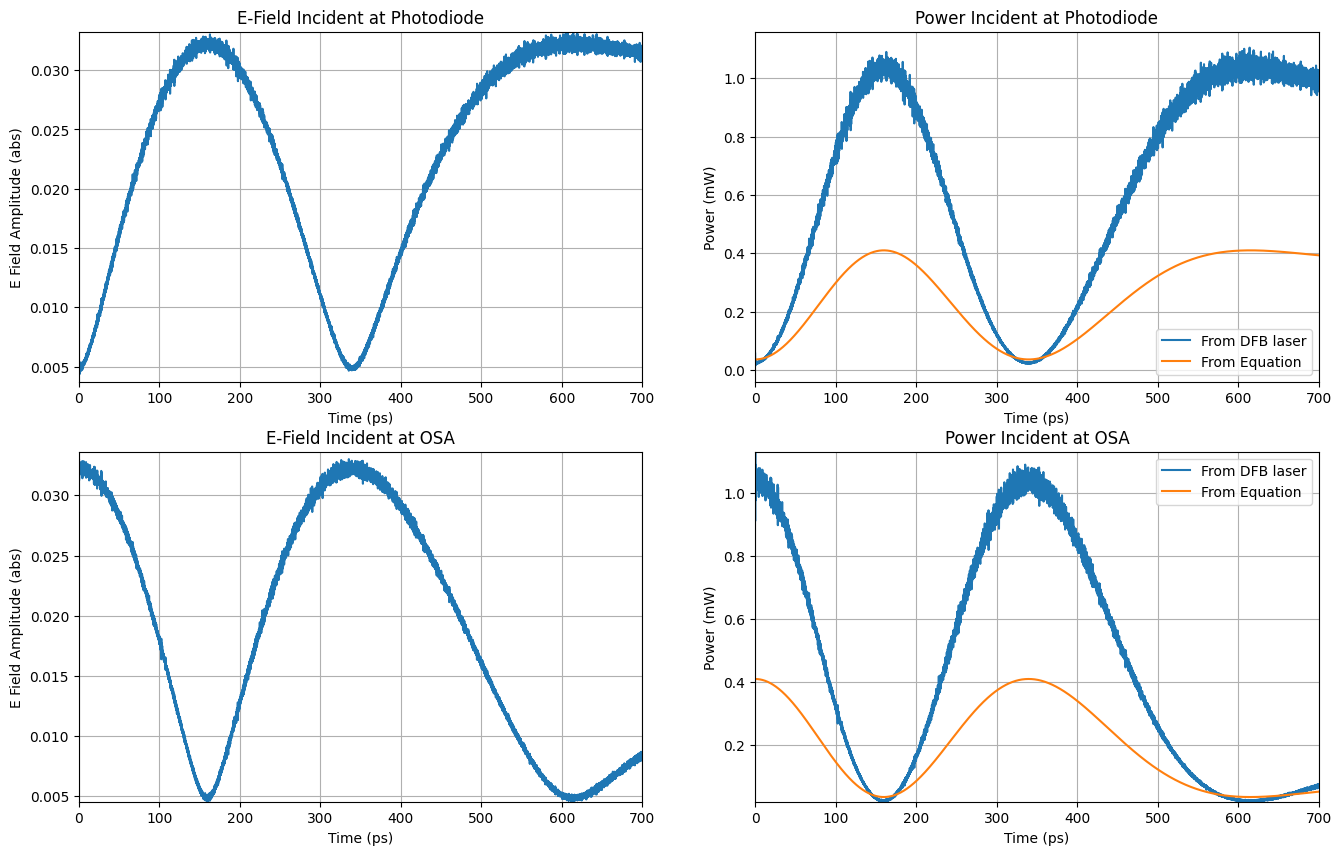

In [120]:
carrier = laser1.e_out*np.sqrt(1-KConst)*np.exp(KPhase*1j)  # Bottom arm Optical signal
b = 10           # Modulation index of the electrical modulating signal
mFreq = 2e9     # Frequency of the electrical modulating signal (Hz)
mPhase = 0      # Phase of the electrical modulating signal (Radians)

EBottom = carrier*np.exp(1j*b*np.sin(mFreq*timeArray+mPhase))

Epd = KConst*EUpper + (1-KConst)*np.exp(1j*KPhase)*EBottom   # E-Field Incident on Photodiode
Eosa = (1-KConst)*np.exp(1j*KPhase)*EUpper + KConst*EBottom  # E-Field Incident on OSA

# Model equations -------------------------------------------------------------

meanPower = np.mean(laser1.power)
EUppermodel = KConst*np.sqrt(meanPower)*np.exp(1j*(2*np.pi*EffFreqDeviation*1e9)*timeArray)/((10)**(SMFAtt*SMFLen/10))
EBottommodel = (1-KConst)*np.sqrt(meanPower)*np.exp(1j*(2*np.pi*EffFreqDeviation*1e9)*timeArray)*np.exp(KPhase*1j)*np.exp(1j*b*np.sin(mFreq*timeArray+mPhase))
Emodelpd = KConst*EUppermodel + (1-KConst)*np.exp(1j*KPhase)*EBottommodel
Emodelosa = (1-KConst)*np.exp(1j*KPhase)*EUppermodel + KConst*EBottommodel

fig, ax = plt.subplots(2,2)
fig.set_figheight(10)
fig.set_figwidth(16)

ax[0][0].plot(timeArray*1e12,np.abs(Epd))
ax[0][0].set_xlim(0,700)
ax[0][0].set_ylim(np.min(np.abs(Epd)),np.max(np.abs(Epd)))
ax[0][0].set_xlabel('Time (ps)')
ax[0][0].set_ylabel('E Field Amplitude (abs)')
ax[0][0].set_title('E-Field Incident at Photodiode')
ax[0][0].grid()

ax[0][1].plot(timeArray*1e12,np.abs(Epd)**2*1e3, label='From DFB laser')
ax[0][1].plot(timeArray*1e12,np.abs(Emodelpd)**2*1e3, label='From Equation')
ax[0][1].set_xlim(0,700)
# ax[0][1].set_ylim(np.min(np.abs(Epd)**2)*1e3,np.max(np.abs(Epd)**2)*1e3)
ax[0][1].set_xlabel('Time (ps)')
ax[0][1].set_ylabel('Power (mW)')
ax[0][1].set_title('Power Incident at Photodiode')
ax[0][1].grid()
ax[0][1].legend()

ax[1][0].plot(timeArray*1e12,np.abs(Eosa))
ax[1][0].set_xlim(0,700)
ax[1][0].set_ylim(np.min(np.abs(Eosa)),np.max(np.abs(Eosa)))
ax[1][0].set_xlabel('Time (ps)')
ax[1][0].set_ylabel('E Field Amplitude (abs)')
ax[1][0].set_title('E-Field Incident at OSA')
ax[1][0].grid()

ax[1][1].plot(timeArray*1e12,np.abs(Eosa)**2*1e3, label='From DFB laser')
ax[1][1].plot(timeArray*1e12,np.abs(Emodelosa)**2*1e3, label='From Equation')
ax[1][1].set_xlim(0,700)
ax[1][1].set_ylim(np.min(np.abs(Eosa)**2)*1e3,np.max(np.abs(Eosa)**2)*1e3)
ax[1][1].set_xlabel('Time (ps)')
ax[1][1].set_ylabel('Power (mW)')
ax[1][1].set_title('Power Incident at OSA')
ax[1][1].grid()
ax[1][1].legend()

# freq, spectrum = get_spectrum(Eosa, Fs=Fs, Fc=c/laser1.lmbd, xunits='hz' )
# ax[1][0].plot(freq,spectrum)

# Heavy Simulation 

In [ ]:
laser_dfb_parameters = parameters()
laser_dfb_parameters.noise_terms = True
laser_dfb_parameters.v       = 1.0       # [cm3]  active layer volume
laser_dfb_parameters.tau_n   = 0.33e-9   # [s]    electron lifetime
laser_dfb_parameters.a0      = 2.50e-6   # [cm2]  active layer gain coefficient
laser_dfb_parameters.vg      = 4.52e+9   # [cm/s] group velocity
laser_dfb_parameters.n_t     = 8.2e6     # [cm-1] carrier density at transparency
laser_dfb_parameters.epsilon = 4.58e-8   # [cm3] gain compression factor
laser_dfb_parameters.tau_p   = 7.15e-12  # [s] photon lifetime
laser_dfb_parameters.gamma   = 1.0       # mode confinement factor
laser_dfb_parameters.beta    = 3.54e-5   # fraction of spontaneous emission coupling
laser_dfb_parameters.alpha   = 1.55      # linewidth enchancement factor
laser_dfb_parameters.sigma   = 2e-20     # gain cross section
laser_dfb_parameters.i_bias  = 0.0129    # [A] i_bias
laser_dfb_parameters.i_max   = 0.0300    # [A] i_max
laser_dfb_parameters.eta_0   = 0.21      # total differential quantum efficiency
laser_dfb_parameters.lmbd    = 1540e-9   # [m] wavelength